In [2]:
%load_ext rpy2.ipython
import os, subprocess, shutil, sys
import pandas as pd
import numpy as np

<a id=top></a>

# Figures for manuscript
## Supplementary manuscript figures
#### FigSI1. [5% Quantile of RM Distribution](#figSI1)
#### FigSI2. [Distributions of RM in Prokaryotes- Without posthoc TIIG](#figSI2)
#### FigSI3. [Distributions of RM in Synechococcus Genomes](#figSI3)
#### FigSI4. [LHS ratio](#figSI4)
#### FigSI5. [Protein Sizes of Methyltransferases](#figSI5)
#### FigSI6. [COR Analysis of Parallel and General Models](#figSI6)
#### FigSI6. [COR Analysis of Memory Model](#figSI7)

<a id=figSI1></a>

## Figure SI1: 5% Quantile of RM Distribution

[Top of Page](#top)

In [2]:
%%R 
library("ggplot2")
library('ggrepel')#this package is not supported on windows!

get_95CI <- function(s,n) {
  return(qnorm(0.975)*s/sqrt(n))
}

custom_colorscale<-scale_colour_manual(values = c("Chloroflexi" = "red",
                                                  "Cyanobacteria" = "springgreen4",
                                                  "Euryarchaeota"="red4",
                                                  "Fibrobacteres" = "lightsalmon3",
                                                  "Proteobacteria"="cornflowerblue",
                                                  "Spirochaetes"="hotpink1",
                                                  "Actinobacteria"="gold4",
                                                  "Bacteroidetes"="cyan3",
                                                  "Chlamydiae"="plum4",
                                                  "Crenarchaeota"="grey0",
                                                  "Firmicutes"="orange1",
                                                  "Fusobacteria" = "deeppink"))

ylab="Complete RM systems per Genome"
xlab="Genome Size (Mbp)"
axis_text_size=13

dat<-read.csv('NotebooksAndData/RMsearch/data/generadat.csv')
dat<-subset(dat,num_isolates >=5)
dat$Mbp<-dat$bp/1000000
dat$RMCI <-get_95CI(dat$rmTotal_std,dat$num_isolates)
dat$MbpCI <-get_95CI(dat$bp_std,dat$num_isolates)/1000000

RM05 = quantile(dat$rmTotal, .05)
dat.RM05 <- dat[dat['rmTotal'] <= RM05,] #restriction above line
dat.RM05 <- dat.RM05[dat.RM05['rmTotal']+dat.RM05['RMCI'] <= RM05,] #restriction to CI that is not below RM95.pT2G
dat.RM05 <- dat.RM05[!grepl("Candidatus", dat.RM05$genus),]

plt05<-ggplot(data = dat.RM05, aes(x=Mbp,y=rmTotal, color=phyla, label=genus) )+
  geom_point()+
  geom_errorbar(aes(ymin=rmTotal-RMCI,ymax=rmTotal+RMCI),alpha=.25)+
  geom_errorbarh(aes(xmin=Mbp-MbpCI,xmax=Mbp+MbpCI),alpha=.25)+
  labs(y=ylab,
       x = xlab)+
  theme_bw()+ 
  theme(panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size),
        legend.text=element_text(size=axis_text_size),
        legend.title=element_text(size=axis_text_size),
       legend.position=c(.8,.55))+
  guides(color=guide_legend(title="Phylum"))
plt05<- plt05+ geom_text_repel(size=5,max.iter=5000,segment.alpha=.5,
                               arrow = grid::arrow(length = unit(0.05, "inches"),type="closed")) #+ 
  #theme(legend.background = element_rect(color = "black", size = .25, linetype = "solid"))

ggsave('figures/SI/RM05Quantile.png',plot=plt05,width=8,height=6,device='png',dpi=900)

<a id=figSI2></a>
## Figure SI2: Distributuion of all prokaryotes
    - 5 or more isolates per data point
    - hexagons rendered when there are 5 or more datapoints
    
[Top of Page](#top)

In [2]:
orgdat = pd.read_csv('NotebooksAndData/RMsearch/data/orgdat.csv')
cyanogen = pd.read_csv('NotebooksAndData/RMsearch/data/cyanodat.csv')
cyanoorg = orgdat[orgdat['phyla'] == 'Cyanobacteria']
g = set(cyanogen[cyanogen['num_isolates'] >=5]['genus'])
g.add("Raphidiopsis")
g.add("Trichodesmium")
g.add("Dolichospermum")

cyanoorg = cyanoorg[cyanoorg['genus'].isin(g)]

[1] 0.09117966
       5% 
0.3848214 


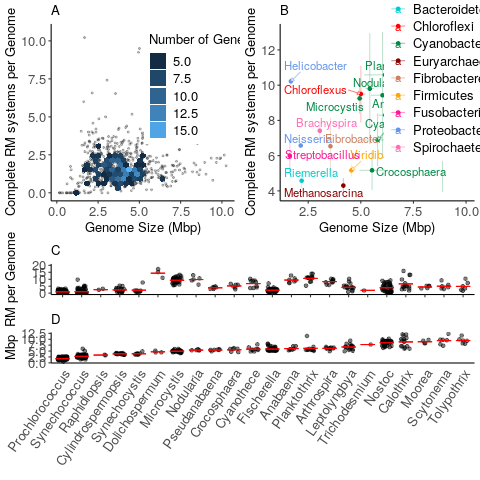

In [4]:
%%R -i cyanoorg
library("ggplot2")
#library("sandwich")
library("hexbin")
library("MASS")
library('ggrepel')#this package is incompatible with windows!
library("pscl")
library("gridExtra")


get_legend<-function(a.gplot){
    tmp <- ggplot_gtable(ggplot_build(a.gplot))
    leg <- which(sapply(tmp$grobs, function(x){x$name}) == "guide-box")
                        legend <- tmp$grobs[[leg]]
  return(legend)}



suppress_hexbin <- function(data, x, y, threshold = 0, bins=30,
                            points_alpha=0.25, point_size=1){
  # pre-summarise the data
  hexinfo <- hexbin(dat[,x], dat[,y], xbins=bins)
  # Extract the _centers_ of the hexagons as the x and y coordinates
  df_hex <- data.frame(hcell2xy(hexinfo), count=hexinfo@count)
  return(
    ggplot(subset(df_hex,count>threshold),aes(x,y,fill=count)) +
      geom_point(data=dat, mapping=aes(dat[,x], dat[,y]),inherit.aes = FALSE, alpha = points_alpha, size = point_size)+
      geom_hex(stat="identity")
  )
}

get_95CI <- function(s,n) {
  return(qnorm(0.975)*s/sqrt(n))
}

dat<-read.csv('NotebooksAndData/RMsearch/data/generadat.csv')
#MODIFICAITON FROM ORIGIONAL SCRIPT#
dat$rmTotal= dat$rmTotal - dat$T2G_posthoc
####################################
dat$Mbp<-dat$bp/1000000
dat.all <-dat
#RESTRICTING BY GENERA WITH 5 OR MORE ISOLATES
dat<-subset(dat,num_isolates >=5)
rm95 = quantile(dat$rmTotal, .95)
mbp95 = quantile(dat$Mbp, .95)
#adding data elements to caption, title
len = nrow(dat)
meanrm = mean(dat$rmTotal)
CIrm = print(get_95CI(sd(dat$rmTotal),length(dat$rmTotal)))

medianrm = median(dat$rmTotal)
#assigning points for either binhex or geompoint
dat_points=subset(dat,rmTotal > rm95 | Mbp > mbp95 )
dat_bin=subset(dat,rmTotal <= rm95 & Mbp <= mbp95 )


ylab="Complete RM systems per Genome"
xlab="Genome Size (Mbp)"
axis_text_size=13

A <- suppress_hexbin(data = dat, x='Mbp',y='rmTotal', threshold = 4, point_size=.75 )+
  labs(y=ylab,x = xlab,
       title='A')+
  theme_bw() + 
  theme(panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"), 
        legend.position=c(.825,.65),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size),
        legend.text=element_text(size=axis_text_size),
        legend.title=element_text(size=axis_text_size))+
  guides(fill=guide_legend(title="Number of Genera"))


################# 95% PLOTS ################################

custom_colorscale<-scale_colour_manual(values = c("Chloroflexi" = "red",
                                                  "Cyanobacteria" = "springgreen4",
                                                  "Euryarchaeota"="red4",
                                                  "Fibrobacteres" = "lightsalmon3",
                                                  "Proteobacteria"="cornflowerblue",
                                                  "Spirochaetes"="hotpink1",
                                                  "Actinobacteria"="gold4",
                                                  "Bacteroidetes"="cyan3",
                                                  "Chlamydiae"="plum4",
                                                  "Crenarchaeota"="grey0",
                                                  "Firmicutes"="orange1",
                                                  "Fusobacteria" = "deeppink"))

dat$RMCI <-get_95CI(dat$rmTotal_std,dat$num_isolates)
dat$MbpCI <-get_95CI(dat$bp_std,dat$num_isolates)/1000000

RM95 = quantile(dat$rmTotal, .95)
dat.RM95 <- dat[dat['rmTotal'] >= RM95,] #restriction above line
dat.RM95 <- dat.RM95[dat.RM95['rmTotal']-dat.RM95['RMCI'] >= RM95,] #restriction to CI that is not below RM95.pT2G

print(quantile(dat$rmTotal, .05))

B<-ggplot(data = dat.RM95, aes(x=Mbp,y=rmTotal, color=phyla, label=genus) )+
  geom_point()+
  geom_errorbar(aes(ymin=rmTotal-RMCI,ymax=rmTotal+RMCI),alpha=.25)+
  geom_errorbarh(aes(xmin=Mbp-MbpCI,xmax=Mbp+MbpCI),alpha=.25)+
  labs(y=ylab,
       x = xlab,title='B')+
  theme_bw() + 
  theme(panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        legend.position=c(.84,.75),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size),
        legend.text=element_text(size=axis_text_size),
        legend.title=element_text(size=axis_text_size))+
  guides(color=guide_legend(title="Phylum"))+custom_colorscale

B<- B+ geom_text_repel(size=4,max.iter=5000,segment.alpha=.5,
                               arrow = grid::arrow(length = unit(0.05, "inches"),
                                                   type="closed"))

##################CYANOBACTERIA########      
cyano.org<-read.csv('NotebooksAndData/RMsearch/data/cyanodat.csv')
cyano.org$Mbp<-cyano.org$bp/1000000
cyano.org.iso5 <- subset(cyano.org,num_isolates >= 5 | 
                         genus == "Raphidiopsis" | 
                         genus == "Trichodesmium"|
                         genus == "Dolichospermum")

cyano.org.iso5$genus<- factor(cyano.org.iso5$genus, 
                              levels = unique(cyano.org.iso5$genus[order(cyano.org.iso5$bp)]))

cyanoorg$Mbp<- cyanoorg$bp/1000000
cyanoorg$rmperMbp <-cyanoorg$rmTotal/cyanoorg$Mbp
cyanoorg$genus<- factor(cyanoorg$genus, 
                        levels = unique(cyano.org.iso5$genus[order(cyano.org.iso5$bp)]))

#MODIFICAITON FROM ORIGIONAL SCRIPT#
cyanoorg$rmTotal= cyanoorg$rmTotal - cyanoorg$T2G_posthoc
####################################

C<- ggplot(cyanoorg,aes(y=rmTotal,x=genus))+
  #geom_boxplot()+
  geom_jitter(alpha = 0.5,width = 0.25)+ 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
                 width = .75, color = 'red')+
  labs(y="RM per Genome",x = element_blank(),
       title='C')+
  theme_bw() + 
  theme(axis.text.x = element_blank(),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size))+
  ylim(c(0,20))

D<- ggplot(cyanoorg,aes(y=Mbp,x=genus))+
  geom_jitter(alpha = 0.5,width = 0.25)+ 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
                 width = .75, color = 'red')+
  labs(y="Mbp",x = element_blank(),title='D')+
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 55, hjust = 1),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),axis.ticks.x=element_blank(),
        axis.text=element_text(size=axis_text_size),
        axis.title=element_text(size=axis_text_size))#+
  #ylim(c(0,12))
gC<-ggplotGrob(C)
gD <- ggplotGrob(D)
CD <- rbind(gC,gD)


#CD<-grid.arrange(C,D, ncol=1,heights=c(3.5,1.5))


plt<-grid.arrange(
    A,B,CD,
    nrow=2,
    layout_matrix = rbind(c(1,2),
                         c(3,3))
)
ggsave('figures/SI/Figure1_noT2G.png',plot=plt,width=12,height=10,device='png',dpi=900)


<a id=figSI3></a>
## Figure SI3: Distributuion of RM in Synechoccocus genomes
    - 5 or more isolates per data point
    - hexagons rendered when there are 5 or more datapoints
[Top of page](#top)

In [3]:
orgdat = pd.read_csv('NotebooksAndData/RMsearch/data/orgdat.csv')
syndat = orgdat[orgdat['genus'] == 'Synechococcus']

#The following is from 10.7717/peerj.1522
syn=[['PCC6301','GCF_000010065','Freshwater','syn','fresh'],
['PCC7942','GCF_000012525','Freshwater','syn','fresh'],
['BL107','GCF_000153805','Mediterranean','para','marine'],
['CB0101','GCF_000179235','Chesapeake Bay','para','marine'],
['CB0205','GCF_000179255','Chesapeake Bay','para','marine'],
['CC9311','GCF_000014585','California current, Pacific (coastal)','para','marine'],
['CC9605','GCF_000012625','California current, Pacific (oligotrophic)','para','marine'],
['CC9902','GCF_000012505','California current, Pacific (oligotrophic)','para','marine'],
['JA23Ba213','GCF_000013225','Octopus Spring, Yellowstone Park','syn','fresh'],
['JA33Ab','GCF_000013205','Octopus Spring, Yellowstone Park','syn','fresh'],
['PCC6312','GCF_000316685','Freshwater, California','syn','fresh'],
['PCC 7002','GCF_000019485','Unknown','syn',''],
['PCC 7335','GCF_000155595','intertidal zone, Puerto Penasco, Mexico','syn','marine'],
['PCC 7336','GCF_000332275','Sea Water Tank, Berkey University','syn','marine'],
['PCC 7502','GCF_000317085','Sphagnum bog','syn','fresh'],
['RCC307','GCF_000063525','Mediterranean','para','marine'],
['RS9916','GCF_000153825','Gulf of Aqaba, Red Sea','para','marine'],
['RS9917','GCF_000153065','Gulf of Aqaba, Red Sea','para','marine'],
['WH 5701','GCF_000153045','Long Island Sound, USA','para','marine'],
['WH 7803','GCF_000063505','Sargasso Sea','para','marine'],
['WH 7805','GCF_000153285','Sargasso Sea','para','marine'],
['WH 8016','GCF_000230675','Woods Hole, MA, USA','para','marine'],
['WH 8102','GCF_000195975','Sargasso Sea','para','marine'],
['WH 8109','GCF_000161795','Sargasso Sea','para','marine']]

for row in syn:
    if row[3] == 'para':
        row[3] = 'Parasynechoccus'
    elif row[3] == 'syn':
        row[3] = 'Synechoccus'
    if row[4] == 'fresh':
        row[4] = 'Fresh Water'
    elif row[4] == 'marine':
        row[4] = 'Marine'
#Following are from https://www.nature.com/articles/s41396-018-0287-6
syn_rmTotal = {el[0]:el[-1] for el in syndat.itertuples(index=False)}
syndf=pd.DataFrame(syn)
syndf.columns = ['straindID','assembly','Isolation_location','Phylogeny','type']
syndf['rmTotal'] = [syn_rmTotal[el] for el in syndf['assembly']]

In [4]:
syndf

,straindID,assembly,Isolation_location,Phylogeny,type,rmTotal
0,PCC6301,GCF_000010065,Freshwater,Synechoccus,Fresh Water,3
1,PCC7942,GCF_000012525,Freshwater,Synechoccus,Fresh Water,3
2,BL107,GCF_000153805,Mediterranean,Parasynechoccus,Marine,1
3,CB0101,GCF_000179235,Chesapeake Bay,Parasynechoccus,Marine,0
4,CB0205,GCF_000179255,Chesapeake Bay,Parasynechoccus,Marine,0
5,CC9311,GCF_000014585,"California current, Pacific (coastal)",Parasynechoccus,Marine,0
6,CC9605,GCF_000012625,"California current, Pacific (oligotrophic)",Parasynechoccus,Marine,0
7,CC9902,GCF_000012505,"California current, Pacific (oligotrophic)",Parasynechoccus,Marine,0
8,JA23Ba213,GCF_000013225,"Octopus Spring, Yellowstone Park",Synechoccus,Fresh Water,2
9,JA33Ab,GCF_000013205,"Octopus Spring, Yellowstone Park",Synechoccus,Fresh Water,1


/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: magrittr

  warnings.warn(x, RRuntimeWarning)
/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘ggpubr’


  warnings.warn(x, RRuntimeWarning)
/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked _by_ ‘.GlobalEnv’:

    get_legend


  warnings.warn(x, RRuntimeWarning)


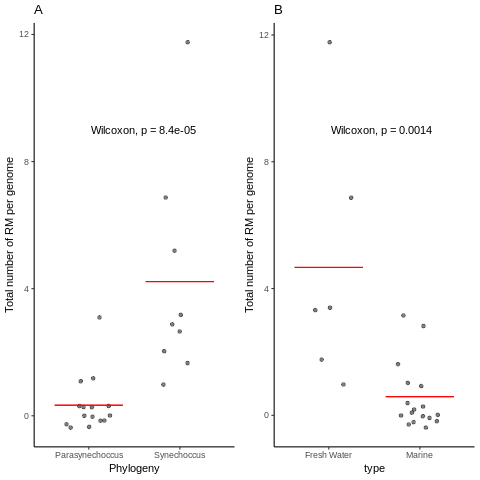

In [8]:
%%R -i syndf
#This cell is used to experiment with poisson modeling
library("ggplot2")
library("sandwich")
library("hexbin")
library("MASS")
library('ggrepel')
library("pscl")
library("gridExtra")
library("ggpubr")
A<-ggplot(syndf, aes(x=Phylogeny,y=rmTotal))+
  #geom_boxplot()+ 
  geom_jitter(alpha = 0.5,width = 0.25)+ 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
                 width = .75, color = 'red')+
  stat_compare_means(label.x.npc=.25, label.y.npc=.75)+
  labs(title='A', y='Total number of RM per genome')+
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))

syndf2 <- subset(syndf, type=='Marine' | type=='Fresh Water',)
B<-ggplot(syndf2, aes(x=type,y=rmTotal))+
  #geom_boxplot()+
  geom_jitter(alpha = 0.5,width = 0.25)+ 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
                 width = .75, color = 'red')+
  stat_compare_means(label.x.npc=.25, label.y.npc=.75)+
  labs(title='B', y='Total number of RM per genome')+
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))

gridplt<-grid.arrange(A,B, 
                      nrow = 1)
ggsave('figures/SI/SYN.png',plot=gridplt,device='png',width=7.5,height=5,dpi=600)

<a id=figSI4></a>
## Figure SI4: LHS Ratio


[Top of page](#top)

In [3]:
def process_LHS(results):
    #We must provide a floor for our data to .1 so we can visualize in logspace.
    #our floor will be 1 (not inclusive) and we will fix these datapoints at an abundance of .1
    Dtemp=[]
    Ctemp=[]
    results['Sr']=results['Sr'].round()
    for el in results['Defense Specialist']:
        if el <1:
            Dtemp.append(1)
        else:
            Dtemp.append(el)
    for el in results['Competition Specialist']:
        if el <1:
            Ctemp.append(1)
        else:
            Ctemp.append(el)
    results['Defense Specialist']=Dtemp
    results['Competition Specialist']=Ctemp
    S_rng = set(results['Sr'])
    m=[]
    qh=.75
    ql=.25
    for S in S_rng:
        df = results[results['Sr'] == S][['Competition Specialist','Defense Specialist']]
        rep_num=len(df)
        t=list(pd.concat([df.mean(),df.median(),df.std(),df.quantile(qh),df.quantile(ql)]))
        t.append(rep_num)
        t.append(S)
        m.append(t)
    df = pd.DataFrame(m)
    #building column names for stats of each treatment
    stats=['mean','median','std','qh','ql','rep_num',"Sr"]
    col=[]
    for stat in stats[:-2]:
        col.append('C'+stat)
        col.append('D'+stat)
    col.extend(stats[-2:])
    df.columns=col
    results['ratio'] = results['Defense Specialist']/results['Competition Specialist']
    ratio = results[['Sr','rep','ratio']]

    #Here, we are sampling 100 points in logspace so we can make bins
    bins = np.logspace(np.log10(ratio['Sr'].min()),np.log10(ratio['Sr'].max()),50)
    #finding the interval each S belongs to
    ratio['bin'] = pd.cut(ratio['Sr'], bins)
    #Describing the bin as the midpoint of the interval for ploting
    ratio = ratio.dropna()
    ratio['bin_Sr'] = [intS.mid for intS in ratio['bin']]
    ratio= ratio[['Sr','ratio','bin_Sr']]
    return(df,ratio)

gen=pd.read_csv('NotebooksAndData/GenMemODE/data/LHS/general.csv')
df_gen,ratio_gen = process_LHS(gen)

par=pd.read_csv('NotebooksAndData/GenMemODE/data/LHS/Parallel.csv')
df_par,ratio_par = process_LHS(par)

mem=pd.read_csv('NotebooksAndData/GenMemODE/data/LHS/Memory.csv')
df_mem,ratio_mem = process_LHS(mem)

/home/spiro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


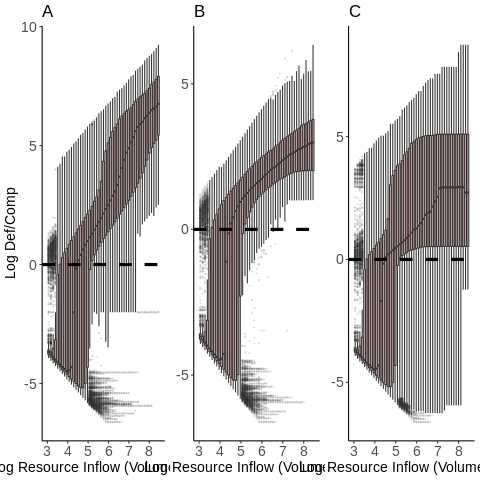

In [7]:
%%R -i ratio_gen,ratio_par,ratio_mem
library("ggplot2")
library("gridExtra")

custom_colorscale<-scale_colour_manual(values = c("b1" = "#009E73", "Competition Specialist"="#009E73",
                                                  "b2" = "#E69F00","Defense Specialist"="#E69F00",
                                                 "p"="#000000","Phage"="#000000",
                                                  "Competition Phage"="#000000","p1"="#000000",
                                                 "p2"="royalblue1","Modified Phage"="royalblue1",
                                                 "Defense Phage"="royalblue1",
                                                 "Defense/Modified Phage"="royalblue1"))

custom_linetype<-scale_linetype_manual(values = c("b1" = "solid", "Competition Specialist"="solid",
                                                  "b2" = "solid","Defense Specialist"="solid",
                                                 "p"="dashed","General Phage"="dashed",
                                                  "Phage"="dashed","p1"="dashed",
                                                 "p2"="dashed","Modified Phage"="dashed",
                                                 "Competition Phage"="dashed","Defense Phage"="dashed",
                                                 "Defense/Modified Phage"="dashed"))


g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) {x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

sim_lim=200                      
ylowerlim = 10^4
yupperlim=10^10
lsize=1
axis_text_size=14

RatVar<-function(ratio){ggplot(ratio, aes(x=bin_Sr, y=ratio,group=bin_Sr))+
  geom_boxplot(notch=FALSE, fill="red",outlier.size=.5,outlier.alpha=.1, alpha=0.2)+#,outlier.shape=NA,)+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  geom_hline(yintercept=1, size=1.5,linetype="dashed", color = "black")+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Def/Comp")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size),title=element_text(size=axis_text_size))}

A<-RatVar(ratio_gen)+labs(title='A')
B<-RatVar(ratio_par)+labs(title='B')
C<-RatVar(ratio_mem)+labs(title='C')

#ggsave("figures/SI/SimpleGeneral.png",plot=A,device="png",dpi=1200)
#ggsave("figures/SI/SimpleParallel.png",plot=B,device="png",dpi=1200)
#ggsave("figures/SI/SimpleMemory.png",plot=C,device="png",dpi=1200)
gridplt<-grid.arrange(A + guides(color=FALSE,linetype=FALSE), 
                      B + theme(axis.title.y=element_blank()),
                      C +guides(color=FALSE,linetype=FALSE)+theme(axis.title.y=element_blank()),
                      nrow = 1,widths=c(1.1,1,1))
ggsave("figures/SI/LHSratios.png",plot=gridplt,width=12,height=4,device="png",dpi=900)


<a id=figSI5></a>
# Size Distribution of RM proteins


[Top of page](#top)


In [32]:
dat = pd.read_csv('NotebooksAndData/RM_Database/definitions/Parameter_exporation/type_length.csv')
code_name = {'M':'Methyltransferase', 'R':"Endonuclease",'RM':"Restriction Modification"}
new_typedat = []

for codetype in list(dat['type']):
    code = codetype.split('_')
    code[-1] = code_name[code[-1]]
    new_typedat.append(' '.join(code))
dat['type'] = new_typedat
keep=[]
dat = dat[ dat['type'].isin(['Type I Methyltransferase',
                            'Type II Methyltransferase',
                            'Type IIG Restriction Modification',
                            'Type III Methyltransferase'])]

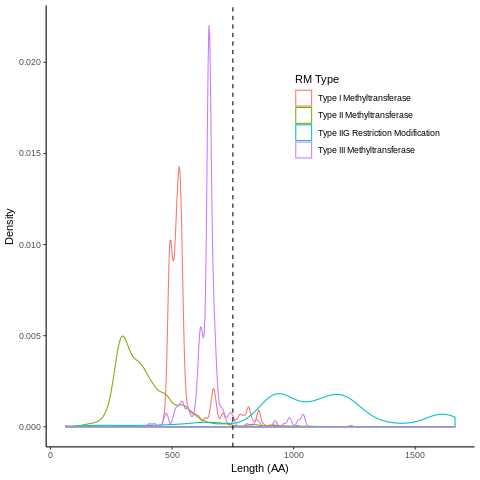

In [33]:
%%R -i dat
library('ggplot2')
library("RColorBrewer")
#cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

A<- ggplot(dat, aes(x=length,color=type))+
  geom_density()+
  labs(color="RM Type", x = "Length (AA)", y = "Density")+
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),axis.line = element_line(colour = "black"),legend.position=c(.75,.75))+
  #scale_colour_manual(values=cbbPalette)+
  geom_vline(xintercept = 750, linetype="dashed")

print(A)

ggsave('figures/SI/RM_sizes.png',plot = A, device='png',width=6,height=5,dpi=600)

<a id=figSI3></a>

<a id=figSI6></a>
# COR of General and Parallel Models


[Top of page](#top)

In [40]:
def COR_df(results):
    Dtemp=[]
    Ctemp=[]
    for el in results['Defense Specialist']:
        if el <1:
            Dtemp.append(1)
        else:
            Dtemp.append(el)
    for el in results['Competition Specialist']:
        if el <1:
            Ctemp.append(1)
        else:
            Ctemp.append(el)
    results['D']=Dtemp
    results['C']=Ctemp
    results['ratio'] = results['D'] / results['C']

    results = results[results['D'] > 1]
    r_df={}
    for r in set(results['r']):
        dat = {'r':[], 'Sr':[], 'd_enter':[], 'd_only':[], 'eql':[]}
        df =results[results['r']== r]
        for Sr in np.sort(np.array(list(set(df['Sr']))),axis=None):
            df_Sr = df[df['Sr']==Sr]

            #d_enter
            d_enter = float(df_Sr['c'].max())

            #removing points where C does not exsist
            df_Sr_C = df_Sr[df_Sr['C'] > 1]

            #d_only
            d_only = float(df_Sr_C['c'].min())

            #df_eql
            #Because dc/dSr is always positive, we will remove
            #datapoints below c from last df_eql to avoid
            #artificats in plots at high nutrients 
            #(where true c is at d_only, but varation in the ratio
            #causes it to be toward the x-axis)
            if dat['eql']:
                #After costs are >.1, use the derivative to determine window size for change
                #
                if dat['eql'][-1] >.25:
                    dc = abs(dat['eql'][-1] - dat['eql'][-2])
                    df_Sr_C = df_Sr_C[df_Sr_C['c'] >= dat['eql'][-1]-dc]
            t = df_Sr_C.iloc[(df_Sr_C['ratio']-1).abs().argsort()[:2]]
            if len(t['c']) == 2:
                #midpoint
                c1,c2 = list(t['c'])
                df_eql = (c1+c2)/2
            elif len(t['c']) == 1:
                df_eql = float(t['c'])

            dat['r'].append(r)
            dat['Sr'].append(Sr)
            dat['eql'].append(df_eql)
            dat['d_enter'].append(d_enter)
            dat['d_only'].append(d_only)
        df = pd.DataFrame(dat)
        Sr_C_extinct = df[df['d_only'] == df['d_only'].min()]['Sr'].max()
        d_only_temp = []
        for index,row in df.iterrows():
            if row['Sr']< Sr_C_extinct:
                d_only_temp.append(np.nan)
            elif pd.isnull(row['d_only']):
                d_only_temp.append(float(row['d_enter']))
            else:
                d_only_temp.append(float(row['d_only']))
        df['d_only'] =d_only_temp
        r_df[r] = df
    return(r_df)
gen= COR_df(pd.read_csv("NotebooksAndData/GenMemODE/data/COR/general.csv"))
par= COR_df(pd.read_csv("NotebooksAndData/GenMemODE/data/COR/Parallel.csv"))

for r in gen:
    gen[r]['r']=r
    gen[r]['model']='gen'
for r in par:
    par[r]['r']=r
    par[r]['model']='par'
    
gen_001 = gen[.001]
gen_01 = gen[.01]
gen_5 = gen[.5]

par_001 = par[.001]
par_01 = par[.01]
par_5 = par[.5]

_=[]
for r in gen:
    _.append(gen[r])
    _.append(par[r])
df=pd.concat(_)

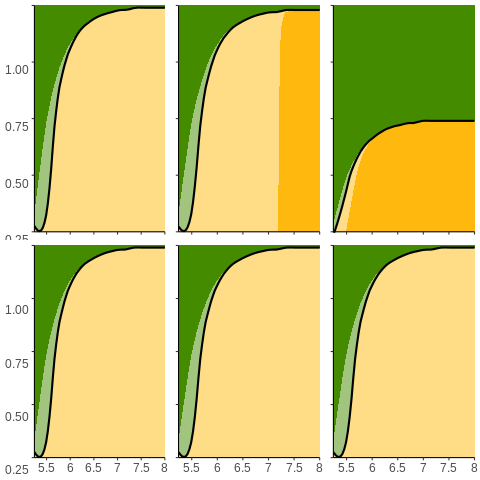

In [51]:
%%R -i gen_001,gen_01,gen_5,par_001,par_01,par_5
library("ggplot2")
library("gridExtra")

axis_text_size=12
sim_lim=200                      
ylowerlim = 10
yupperlim=10^7
lsize=1

COR<-function(df){
    predict_span=.2
    df$eql.pred<-predict(loess(eql ~ Sr,data=df,span=predict_span))
    df$d_enter.pred<-predict(loess(d_enter ~ Sr,data=df,span=predict_span))
    
     if (tail(df$d_only,n=1) != 0.01){
     df$d_only.pred<-predict(loess(d_only ~ Sr,data=df,
                              span=predict_span,na.action = na.exclude))
     gplt<-ggplot(df,aes(y=eql.pred,x=Sr))+
             geom_ribbon(data=df,aes(ymin = 0, ymax = d_only.pred),
                       fill='darkgoldenrod1')
     }else{
         gplt<-ggplot(df,aes(y=eql.pred,x=Sr))
     }
    gplt<-gplt+
      geom_ribbon(aes(ymin = 0, ymax = eql.pred),
                fill='darkgoldenrod1',alpha = 0.5)+
      #geom_ribbon(aes(ymin = 0, ymax = d_only.pred),
      #          fill='darkgoldenrod1')+
      geom_ribbon(aes(ymax = 1, ymin = d_enter.pred),
                fill='chartreuse4')+
      geom_ribbon(aes(ymax = 1, ymin = eql.pred),
                fill='chartreuse4',alpha = 0.5)+
      geom_line(size=1)+
    
      scale_x_log10(
          breaks = scales::trans_breaks("log10", function(x) {10^x}),
          labels = scales::trans_format("log10", scales::math_format(.x)),
          expand=c(0,0))+
      theme_bw()+
      theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
           axis.text=element_text(size=axis_text_size))+
      labs(x="Log Resource Inflow (AU Nutrient/Time)",y="Cost of Resistance")+
    #coord_cartesian(ylim=c(0,1),xlim=c(10^4.5,10^7
      scale_y_continuous(expand = c(0, 0)) +
      coord_cartesian(ylim=c(0,1))

    return(gplt)
}
A<-COR(gen_001)+theme(axis.title=element_blank(),axis.text.x=element_blank())
B<-COR(gen_01)+theme(axis.title=element_blank(),axis.text=element_blank())
C<-COR(gen_5)+theme(axis.title=element_blank(),axis.text=element_blank())
D<-COR(par_001)+theme(axis.title=element_blank())#,axis.text.x=element_blank())
E<-COR(par_01)+theme(axis.title=element_blank(),axis.text.y=element_blank())
F<-COR(par_5)+theme(axis.title=element_blank(),axis.text.y=element_blank())


gridplt<-grid.arrange(A,B,C,
                      D,E,F,
                      nrow = 2,widths=c(1.1,1,1))
ggsave("figures/SI/COR_GenPar.png",plot=gridplt,width=10,height=6,device="png",dpi=1200)

<a id=figSI7></a>
# COR of Memory Model


[Top of page](#top)

In [45]:
pr9=pd.read_csv("NotebooksAndData/GenMemODE/data/pr_r/MEMpr9.csv")
pr5=pd.read_csv("NotebooksAndData/GenMemODE/data/pr_r/MEMpr5.csv")
pr1=pd.read_csv("NotebooksAndData/GenMemODE/data/pr_r/MEMpr1.csv")


r_pr9= COR_df(pr9)
r_pr5= COR_df(pr5)
r_pr1= COR_df(pr1)


pr9_001 = r_pr9[.001]
pr9_01 = r_pr9[.01]
pr9_5 = r_pr9[.5]

pr5_001 = r_pr5[.001]
pr5_01 = r_pr5[.01]
pr5_5 = r_pr5[.5]

pr1_001 = r_pr1[.001]
pr1_01 = r_pr1[.01]
pr1_5 = r_pr1[.5]

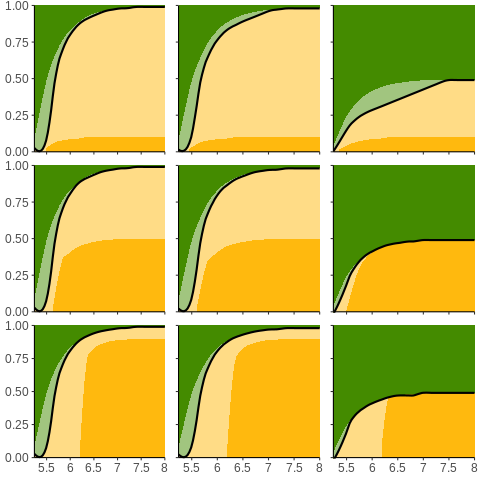

In [48]:
%%R -i pr9_001,pr9_01,pr9_5,pr5_001,pr5_01,pr5_5,pr1_001,pr1_01,pr1_5
library("ggplot2")
library("gridExtra")

axis_text_size=12
sim_lim=200                      
ylowerlim = 10
yupperlim=10^7
lsize=1
A<-COR(pr9_001)+theme(axis.title=element_blank(),,axis.text.x=element_blank())
B<-COR(pr9_01)+theme(axis.title=element_blank(),axis.text=element_blank())
C<-COR(pr9_5)+theme(axis.title=element_blank(),axis.text=element_blank())
D<-COR(pr5_001)+theme(axis.title=element_blank(),axis.text.x=element_blank())
E<-COR(pr5_01)+theme(axis.title=element_blank(),axis.text=element_blank())
F<-COR(pr5_5)+theme(axis.title=element_blank(),axis.text=element_blank())
G<-COR(pr1_001)+theme(axis.title.x=element_blank(),axis.title.y=element_blank())
H<-COR(pr1_01)+theme(axis.title=element_blank(),axis.text.y=element_blank())
I<-COR(pr1_5)+theme(axis.title=element_blank(),axis.text.y=element_blank())

gridplt<-grid.arrange(A,B,C,
                      D,E,F,
                      G,H,I,
                      nrow = 3,widths=c(1.1,1,1))

ggsave("figures/SI/COR_MEM.png",plot=gridplt,width=6,height=6,device="png",dpi=1200)